# Estimating penny population parameters
In this example we'll use a System Dynamics model to estimate the total number of pennies in circulation, based upon the number of pennies produced in a given year, and the number of pennies in a coin jar.

We start with a simple aging model for pennies, in essence a second order delay. Pennies are minted each year, and go into a stock of 'post production' pennies that are distributed to banks, etc. After this they go into general circulation, from which they are eventually lost.
<img src="Aging_Chain.png" alt="Two Cohort Aging Chain" style="width: 700px;"/>

In this analysis we'll try and infer the parameters for entry into circulation and loss based upon the number of pennies produced in each year, and a random sample of pennies taken from circulation over a four year period. An interesting component of this analysis is that it requires a whole suite of models (one for each model year) but these models don't interact with one another except through the sampling and statistical analysis we perform.

In this demo, we'll use 'pymc', a package for doing markov chain monte carlo analysis.

In [1]:
%pylab inline
import pandas as pd
import pysd
import pymc as mc

Populating the interactive namespace from numpy and matplotlib


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Load Model
To get a sense for how the model behaves, we'll run it with arbitrary parameter values. We see that pennies enter the 'post production' stock quickly, and the 'in circulation' stock grows, peaks, and decays as the pennies get lost. 

<AxesSubplot:>

<Figure size 600x200 with 0 Axes>

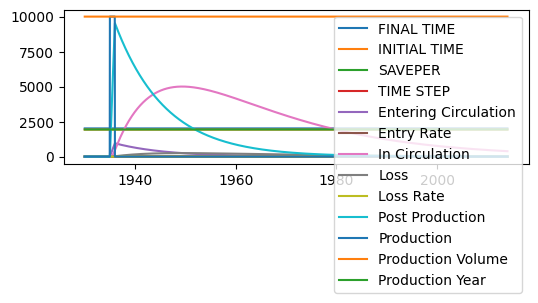

In [2]:
plt.figure(figsize(6,2))
model = pysd.read_vensim('../../models/Penny_Distribution/penny_jar.mdl')
model.run().plot()

### Load Data
We'll start with some data about the number of coins produced in each year. We have production data for both the Denver and Philadelphia mints:

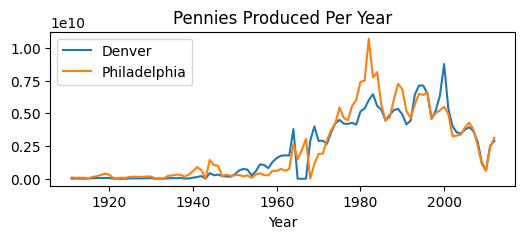

In [3]:
production = pd.read_csv('../../data/Penny_Jar/Production_Figures.csv', index_col='Year')
production.plot()
plt.title('Pennies Produced Per Year');

We'll also use 'data' (pennies) collected in a penny jar over the last few years

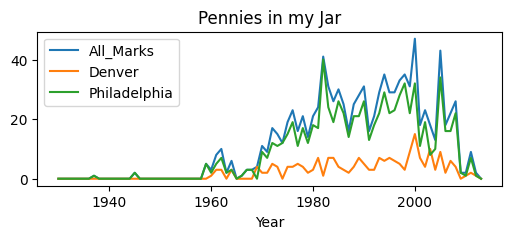

In [4]:
coin_counts = pd.read_csv('../../data/Penny_Jar/pennies_in_jar.csv', index_col='Year')
coin_counts.sort_index().plot()
plt.title('Pennies in my Jar');

In [5]:
coin_counts.sum()

All_Marks       1004
Denver           209
Philadelphia     795
dtype: int64

(1950.0, 2015.0)

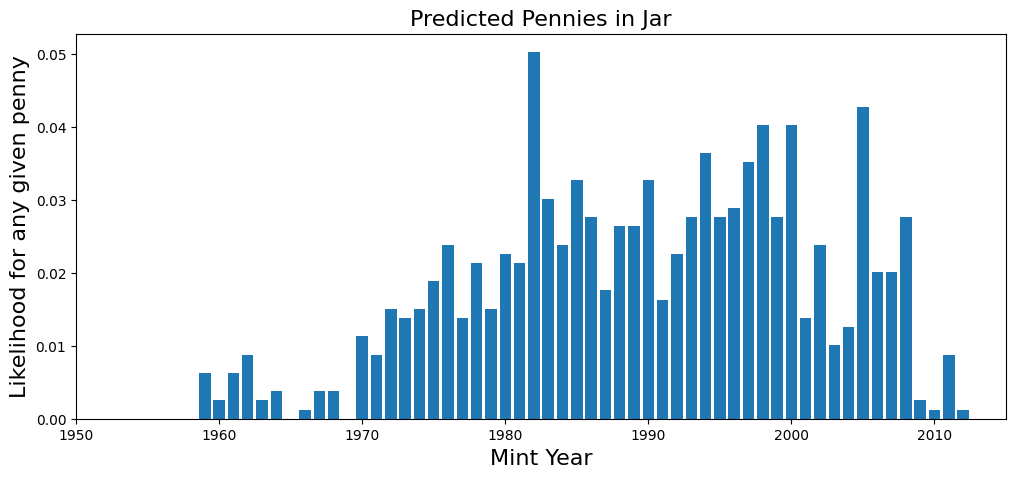

In [6]:
plt.figure(figsize=(12,5))
plt.bar(coin_counts.index, coin_counts['Philadelphia']/sum(coin_counts['Philadelphia']))
plt.title('Predicted Pennies in Jar', fontsize=16)
plt.xlabel('Mint Year', fontsize=16)
plt.ylabel('Likelihood for any given penny', fontsize=16)
plt.xlim(1950,2015)

### Set up models
We set up a model for each year that pennies are produced, and initialize them with production data.

We divide the data to put pennies in units of 100,000 to make life easier for the integrator. This won't matter in the end, as we normalize the distribution of pennies in circulation before we take our samples.


In [7]:
#load a model for each mint year
models = pd.DataFrame(data=[[year, pysd.read_vensim('../../models/Penny_Distribution/penny_jar.mdl')] for year in range(1930,2014)],
                      columns=['Year', 'model'])

models.set_index(keys='Year', drop=False, inplace=True)

#bring in the data on production
models['Philadelphia Production'] = production['Philadelphia'] / 100000 
#production will now be in units of hundred-thousands

#bring in the sample data
models['Philadelphia Samples'] = coin_counts['Philadelphia']

#set the mint year parameters properly
for index, row in models.iterrows():
    row['model'].set_components({'production_year':row['Year'], 'production_volume':row['Philadelphia Production']})

#drop rows (probably at the end) which are missing data
models.dropna(inplace=True) 

models.tail(30).head(5)

,Year,model,Philadelphia Production,Philadelphia Samples
Year,,,,
1983,1983,Translated Model File: ../../models/Penny_Dist...,77523.55000,24
1984,1984,Translated Model File: ../../models/Penny_Dist...,81510.79000,19
1985,1985,Translated Model File: ../../models/Penny_Dist...,56484.89887,26
1986,1986,Translated Model File: ../../models/Penny_Dist...,44913.95493,22
1987,1987,Translated Model File: ../../models/Penny_Dist...,46824.66931,14


### Set up a Markov Chain Monte Carlo Analysis

MCMC works by choosing an arbitrary value from a distribution of input parameters, running the simulation, and asking what the likelihood of the data is given those parameters. It then decides whether to keep the selected parameters to display in an output distribution based upon this likeliood. 

We start then by setting up a 'prior' distribution for the loss rate and entry rate parameters that will be applied to each of the mint year models.

In [ ]:
entry_rate = mc.Uniform.dist('entry_rate', lower=0, upper=.99, value=.08)
loss_rate = mc.Uniform.dist('loss_rate', lower=0, upper=.3, value=.025)

We'll ask our models for the population of coins from which the sample was drawn, and as this happened over a period of time, not all in the same timestep, we'll assume that there is equal likelihood that a sample was drawn (or a penny collected) any time during that window.

We then construct a function that returns to us the likelihood of the data given the distribution of pennies in circulation, as calculated by our model.

PyMC expects this likelihood to be expressed as a log probability, to give resolution in the 'very small likelihood' regimes that our model will predict for our observations.

In [ ]:
def get_population(model, entry_rate, loss_rate):
    in_circulation = model.run(params={'entry_rate':entry_rate, 'loss_rate':loss_rate}, 
                               return_columns=['in_circulation'],
                               return_timestamps=range(2011,2015))
    return in_circulation.mean()

@mc.stochastic(trace=True, observed=True) #stupid observed flag! got to get that right!
def circulation(entry_rate=entry_rate, loss_rate=loss_rate, value=1):
    
    mapfunc = lambda x: get_population(x, 1*entry_rate, 1*loss_rate)
    population = models['model'].apply(mapfunc) 
    
    #transform to log probability and then normalize (in the log domain, just by subtraction)
    log_distribution = np.log(population) - np.log(population.sum())
    
    #calculate the probability of the data from the distribution
    log_prob = (models['Philadelphia Samples'] * log_distribution).sum()
    
    return log_prob

### Perform the MCMC Sampling

In [ ]:
mcmc = mc.MCMC(mc.Model([entry_rate, loss_rate, circulation]))

In [ ]:
#mcmc.sample(20000)
mcmc.sample(10)

### Plot the results

We can plot a histogram of the output of the MCMC analysis, showing the uncertainty in our estimate of the loss rate and entry rate based upon our model and data selection. We also see that these distributions are not entirely independant, by plotting the sample values for each parameter against one another, and using a hex-binned two-dimensional histogram.

In [ ]:
plt.hist(mcmc.trace('loss_rate')[10000:], bins=60, histtype='stepfilled', normed=True)
plt.xlabel('Loss Rate')
plt.title('Loss Rate Likelihood');

In [ ]:
plt.hist(mcmc.trace('entry_rate')[10000:], bins=60, histtype='stepfilled', normed=True)
plt.xlabel('Entry Rate')
plt.title('Entry Rate Likelihood');

In [ ]:
plt.hexbin(mcmc.trace('loss_rate')[:], mcmc.trace('entry_rate')[:], gridsize=30)
plt.xlabel('Loss Rate')
plt.ylabel('Entry Rate');